In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import langdetect
from scipy.stats import sem

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\holger.doerner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\holger.doerner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('lyrics.csv')

                index    song    year  artist  lyrics
genre                                                
Country         17286   17286   17286   17286   14387
Electronic      16205   16205   16205   16205    7966
Folk             3241    3241    3241    3241    2243
Hip-Hop         33965   33965   33965   33965   24850
Indie            5732    5732    5732    5732    3149
Jazz            17147   17145   17147   17147    7971
Metal           28408   28408   28408   28408   23759
Not Available   29814   29814   29814   29814   23941
Other           23683   23683   23683   23683    5189
Pop             49444   49444   49444   49444   40466
R&B              5935    5935    5935    5935    3401
Rock           131377  131377  131377  131377  109235


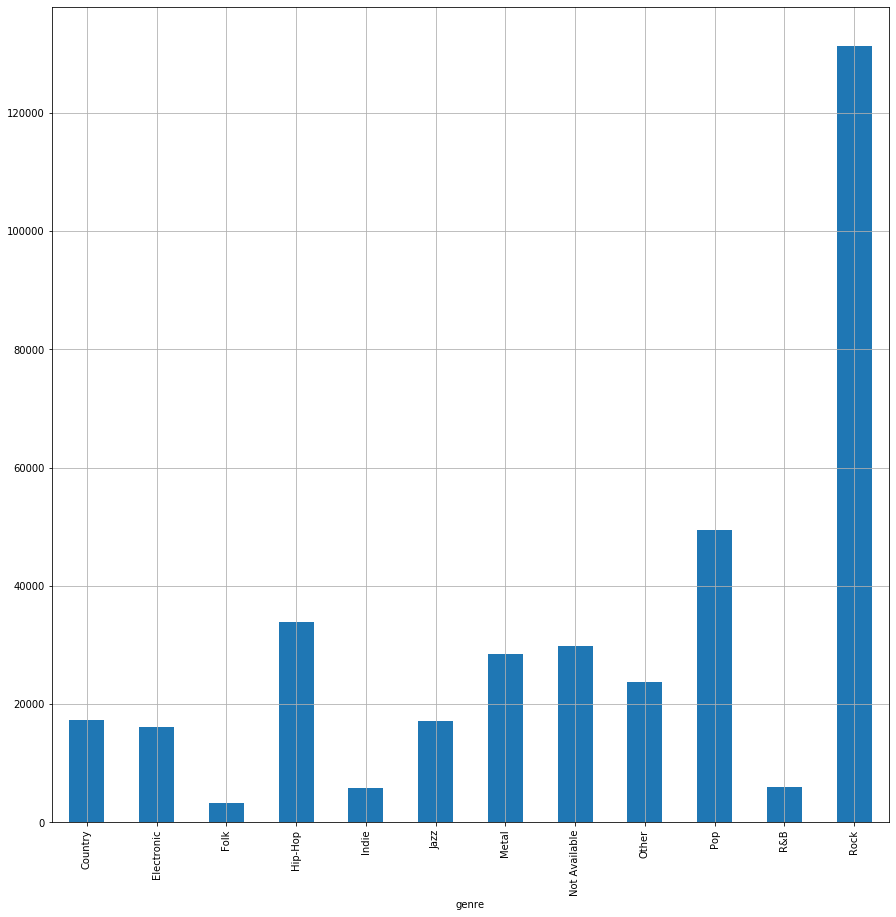

In [494]:
df.groupby('genre')['genre'].count().plot(kind='bar', grid=True, figsize=(15,15))
print(df.groupby('genre').count())

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

class column_selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]
    

class genre_selector(BaseEstimator, TransformerMixin):
    def __init__(self, genres):
        self.genres = genres
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X[X['genre'].isin(self.genres)]
        return X
    
    
class remove_na(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if type(self.columns) is list:
            for column in self.columns:
                X = X[X[column].notnull()]
        else:
            X = X[X[self.columns].notnull()]
        return X
    
    
class clean_lyrics(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmer = WordNetLemmatizer()
        # remove all special chars, symbols and numbers
        X['lyrics'] = X['lyrics'].replace(r'[^A-Za-z]', ' ', regex=True)
        # remove all single characters surrounded by whitepace
        X['lyrics'] = X['lyrics'].replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
        # remove single characters at beginning of text
        X['lyrics'] = X['lyrics'].replace(r'\^[a-zA-Z]\s+', ' ', regex=True)
        # replace repeated whitespaces with single whitespace
        X['lyrics'] = X['lyrics'].replace(r'\s+', ' ', regex=True, flags=re.I)
        # replaces repeated chars by two ('aaaaaaah' => 'aah', 'helllloooooooo' => 'helloo')
        X['lyrics'] = X['lyrics'].replace(r'(.)\1{2,}', r'\1\1', regex=True, flags=re.I)
        # converts all to lowercase
        X['lyrics'] = X['lyrics'].str.lower()
        # lemmatizes words ('am, are, is => be', 'car, cars, car's, cars' => car')
        X['lyrics'] = X['lyrics'].map(lambda s: ' '.join([stemmer.lemmatize(w) for w in s.split()]))
        # remove leading and trailing whitespaces
        X['lyrics'] = X['lyrics'].str.strip()
        return X
    
    
class lyrics_length_selector(BaseEstimator, TransformerMixin):
    def __init__(self, lyric_length=100):
        self.lyric_length = lyric_length
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[X['word_count'] >= self.lyric_length]
    
    
class mask_buzzwords(BaseEstimator, TransformerMixin):
    def __init__(self, buzzwords, mask):
        self.buzzwords = buzzwords
        self.mask = mask
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for word in self.buzzwords:
            X['lyrics'] = X['lyrics'].str.replace(word, self.mask, regex=True, flags=re.I)
        return X
    
    
class compute_word_count(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['word_count'] = X['lyrics'].map(lambda s: len(s.split()))
        return X
    
    
class detect_language(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def _compute(self, sentence):
        lang = ''
        try:
            lang = langdetect.detect(sentence)
        except:
            lang = 'unknown'
        return lang
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['language'] = X['lyrics'].map(self._compute)
        return X
    
    
class select_language(BaseEstimator, TransformerMixin):
    def __init__(self, languages=['en'], exclude=False):
        self.languages = languages
        self.exclude = exclude
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if not self.exclude:
            X = X[X['language'].isin(self.languages)]
        else:
            X = X[~X['language'].isin(self.languages)]
        return X
    
    
class remove_duplicates(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if type(self.columns) is list:
            for column in self.columns:
                X = X.drop_duplicates(subset=column, keep='first')
        else:
            X = X.drop_duplicates(subset=self.columns, keep='first')
        return X
    
    
class normalize_genre_to_lower(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['genre'] = X['genre'].map(lambda s: s.lower())
        return X

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion

genres = ['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie']

preprocess_pipeline = Pipeline([
    ('remove_na', remove_na(columns=['lyrics', 'genre'])),
    ('remove_duplicates', remove_duplicates(columns=['song', 'lyrics'])),
    ('column_selector', column_selector(columns=['lyrics', 'genre'])),
    ('genre_selector', genre_selector(genres=genres)),
    ('clean_lyrics', clean_lyrics()),
    ('mask_buzzwords', mask_buzzwords(buzzwords=genres, mask='')),
    ('compute_word_count', compute_word_count()),
    ('detect_language', detect_language()),
    ('select_language', select_language(languages=['en'], exclude=False)),
    ('lyrics_length_selector', lyrics_length_selector(lyric_length=100)),
    ('normalize_genre_to_lower', normalize_genre_to_lower())
])

In [5]:
# df_cleaned = preprocess_pipeline.fit_transform(df)
# df_cleaned.to_csv('lyrics_cleaned.csv', index=None, header=True)

df_cleaned = pd.read_csv('lyrics_cleaned.csv')

genre
country        8619
electronic     3423
folk           2905
hip-hop       16320
jazz           2993
metal         12881
pop           18192
rock          57066
Name: genre, dtype: int64


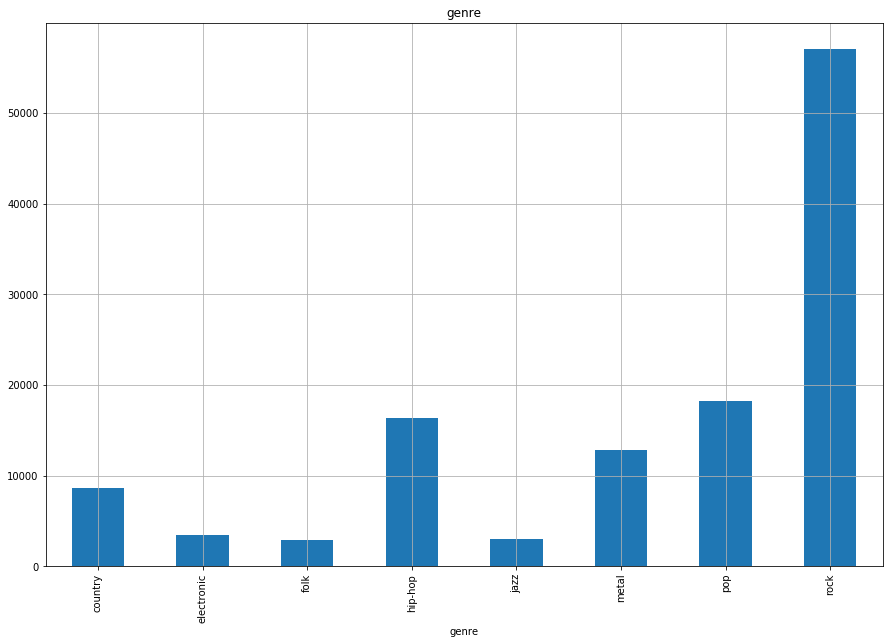

In [6]:
df_cleaned.groupby('genre')['genre'].count().plot(kind='bar', figsize=(15,10), grid=True, subplots=True)
print(df_cleaned.groupby('genre')['genre'].count())

In [167]:
# df_cleaned['lyrics'] = df_cleaned['lyrics'].replace(r'(.)\1{2,}', r'\1\1', regex=True)

# df_cleaned[df_cleaned['lyrics'].str.contains('aaaaaaaaa')].head(1)
# t = df_cleaned.drop_duplicates('lyrics')
df_cleaned.to_csv('lyrics_cleaned.csv', index=None, header=True)

## Feature Engineering

### Combining classes

In [164]:
df_cleaned.loc[df_cleaned['genre'] == 'r&b', 'genre'] = 'hip-hop'
df_cleaned.loc[df_cleaned['genre'] == 'indie', 'genre'] = 'folk'

### Subsampling 2900 random lyrics for each genre
2900 because it is (almost) the maximum number of the smalest category

In [15]:
df_sampled = df_cleaned.groupby('genre').apply(lambda genre: genre.sample(2900, replace=False, random_state=666)).reset_index(level=0, drop=True).reset_index()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000190938D0710>],
      dtype=object)

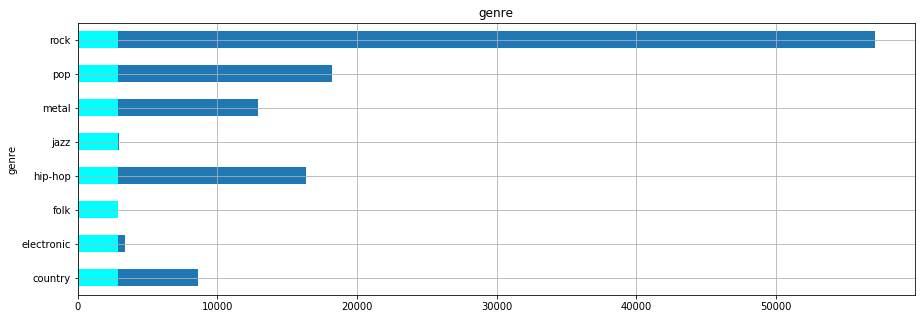

In [30]:
fig = df_cleaned.groupby('genre')['genre'].count().plot(kind='barh', figsize=(15,5), grid=True, subplots=True, stacked=True)
df_sampled.groupby('genre')['genre'].count().plot(kind='barh', figsize=(15,10), grid=True, subplots=True, ax=fig, color='cyan')

### Concatinate the lyrics from each genre to get one large document per genre

<BarContainer object of 8 artists>

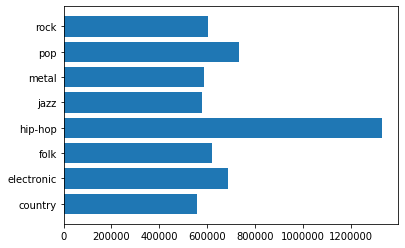

In [26]:
df_sampled_concat = df_sampled.groupby('genre').apply(lambda s: ' '.join(s.lyrics)).reset_index()[0]

plt.barh(lb.classes_, [len(v.split()) for v in df_sampled_concat])

### Use TFIDFVectorizer to create the features and LabelBinarizer to One-Hot encode the classes

In [175]:
vectorizer = TfidfVectorizer(encoding='utf-8', lowercase=True, analyzer='word', stop_words=stopwords.words(['english']),
                       binary=False, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False, max_features=3000, max_df=1.0)

vectorizer.fit(df_sampled_concat.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=3000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [32]:
len(vectorizer.vocabulary_)

1500

In [176]:
X = vectorizer.transform(df_sampled['lyrics'])
X.shape

(23200, 3000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23200 samples in 0.025s...
[t-SNE] Computed neighbors for 23200 samples in 12.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23200
[t-SNE] Computed conditional probabilities for sample 2000 / 23200
[t-SNE] Computed conditional probabilities for sample 3000 / 23200
[t-SNE] Computed conditional probabilities for sample 4000 / 23200
[t-SNE] Computed conditional probabilities for sample 5000 / 23200
[t-SNE] Computed conditional probabilities for sample 6000 / 23200
[t-SNE] Computed conditional probabilities for sample 7000 / 23200
[t-SNE] Computed conditional probabilities for sample 8000 / 23200
[t-SNE] Computed conditional probabilities for sample 9000 / 23200
[t-SNE] Computed conditional probabilities for sample 10000 / 23200
[t-SNE] Computed conditional probabilities for sample 11000 / 23200
[t-SNE] Computed conditional probabilities for sample 12000 / 23200
[t-SNE] Computed conditional probabilities for sa

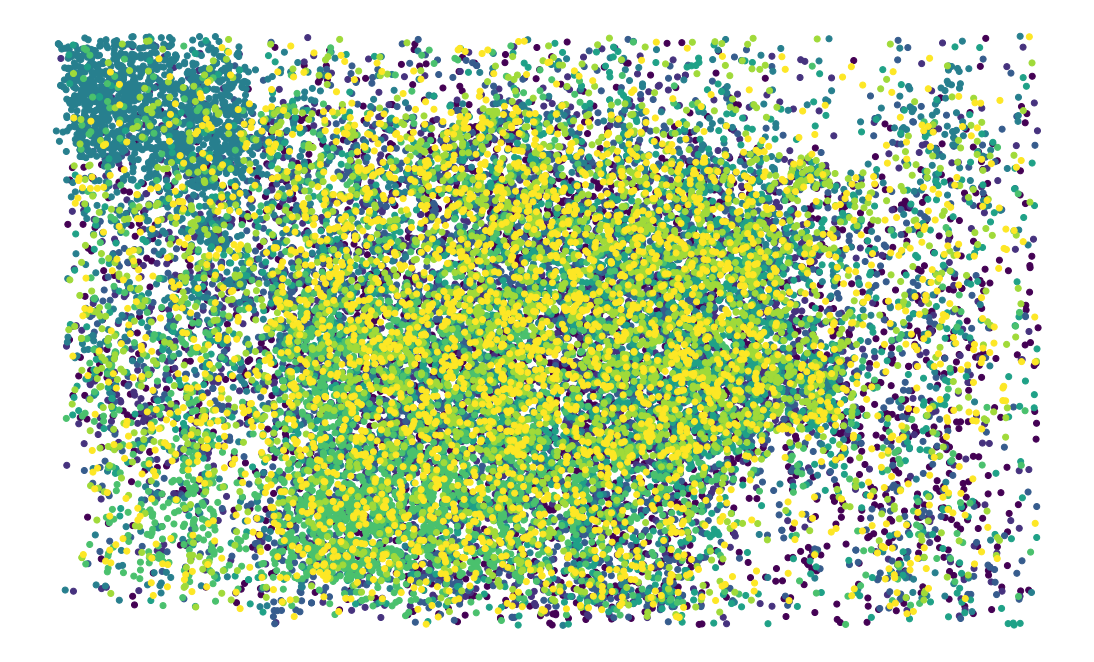

In [295]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

X_reduced = TruncatedSVD(n_components=8).fit_transform(X)
X_embedded = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X_reduced)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
plt.scatter(tfs_embedded[:,0], X_embedded[:,1], c=LabelEncoder().fit_transform(df_sampled['genre']))

In [177]:
lb = LabelBinarizer()
y = lb.fit_transform(df_sampled['genre'])
y.shape

(23200, 8)

### Split the train- and test-sets

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.1, random_state=42, stratify=y)

### Evaluating esteminators

#### SGDClassifier

In [172]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

params = {
    'clf__estimator__loss': ('hinge',),
    'clf__estimator__penalty': ('l2',),
    'clf__estimator__alpha': (0.00000001, 0.0000001, 0.000001, 0.00001),
    'clf__estimator__max_iter': (500, 1000, 2000, 3000),
    'clf__estimator__tol': (1e-3,),
    'clf__estimator__shuffle': (True,),
    'clf__estimator__warm_start': (False,),
    'vect__max_df': (0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    'vect__max_features': (1500, 2000, 2500, 3000, 4000, 5000),
    'vect__stop_words': (stopwords.words(['english']),),
}

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier()))
])

X_train_sgd, X_test_sgd, y_train_sgd, y_test_sgd = train_test_split(df_sampled['lyrics'], df_sampled['genre'], test_size=0.1, random_state=42, stratify=y)

clf_pipeline_sgd = RandomizedSearchCV(pipeline, param_distributions=params, pre_dispatch=4, n_jobs=-1,
                                   cv=10, error_score=np.nan, refit=True, verbose=3)
clf_pipeline_sgd.fit(df_sampled['lyrics'], df_sampled['genre'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                       

In [285]:
print('Train set: ', clf_pipeline_sgd.score(X_train_sgd, y_train_sgd))
print('Test set: ', clf_pipeline_sgd.score(X_test_sgd, y_test_sgd))
clf_pipeline_sgd.best_params_

Train set:  0.6821360153256705
Test set:  0.6844827586206896


{'vect__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again'

In [275]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset="train", categories=categories)
newsgroups.target.size

2034

#### TensorFlow Keras Sequential Model

In [179]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers

model = tensorflow.keras.Sequential([
    layers.Dense(64, input_shape=X_train.shape[1:], activation='relu'),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(8, activation='softmax')
])

# model.compile(loss='binary_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                192064    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 520       
Total params: 196,744
Trainable params: 196,744
Non-trainable params: 0
_________________________________________________________________


In [180]:
model.fit(X_train, y_train, epochs=10, batch_size=32,
         validation_data=(X_test, y_test))

Train on 20880 samples, validate on 2320 samples
Epoch 1/10
20880/20880 [==============================] - 3s 166us/sample - loss: 0.3055 - categorical_accuracy: 0.3874 - val_loss: 0.2928 - val_categorical_accuracy: 0.4293
Epoch 2/10
20880/20880 [==============================] - 3s 142us/sample - loss: 0.2673 - categorical_accuracy: 0.4927 - val_loss: 0.2911 - val_categorical_accuracy: 0.4509
Epoch 3/10
20880/20880 [==============================] - 3s 153us/sample - loss: 0.2463 - categorical_accuracy: 0.5481 - val_loss: 0.2947 - val_categorical_accuracy: 0.4440
Epoch 4/10
20880/20880 [==============================] - 3s 155us/sample - loss: 0.2269 - categorical_accuracy: 0.5949 - val_loss: 0.3092 - val_categorical_accuracy: 0.4431
Epoch 5/10
20880/20880 [==============================] - 3s 151us/sample - loss: 0.2062 - categorical_accuracy: 0.6404 - val_loss: 0.3214 - val_categorical_accuracy: 0.4483
Epoch 6/10
20880/20880 [==============================] - 3s 164us/sample - loss:

In [171]:
model.evaluate(X_test, y_test)

2320/2320 [==============================] - 0s 72us/sample - loss: 0.3489 - categorical_accuracy: 0.3284


[0.3488880307509981, 0.32844827]

---

In [294]:
lyrics = '''Yeah yeah yeah yeah yeah
Yeah yeah yeah yeah yeah yeah
I think I did it again
I made you believe we're more than just friends
Oh baby
It might seem like a crush
But it doesn't mean that I'm serious
'Cause to lose all my senses
That is just so typically me
Oh baby, baby
Oops, I did it again
I played with your heart, got lost in the game
Oh baby, baby
Oops, you think I'm in love
That I'm sent from above
I'm not that innocent'''

lyrics = input()

lyrics = re.sub(r'[^A-Za-z]', ' ', lyrics)
# remove all single characters surrounded by whitepace
lyrics = re.sub(r'\s+[a-zA-Z]\s+', ' ', lyrics)
# remove single characters at beginning of text
lyrics = re.sub(r'\^[a-zA-Z]\s+', ' ', lyrics)
# replace repeated whitespaces with single whitespace
lyrics = re.sub(r'\s+', ' ', lyrics, flags=re.I)
# replaces repeated chars by two ('aaaaaaah' => 'aah', 'helllloooooooo' => 'helloo')
lyrics = re.sub(r'(.)\1{2,}', r'\1\1', lyrics, flags=re.I)
# converts all to lowercase
lyrics = lyrics.lower()
# lemmatizes words ('am, are, is => be', 'car, cars, car's, cars' => car')
lyrics = ' '.join([WordNetLemmatizer().lemmatize(w) for w in lyrics.split()])
# remove leading and trailing whitespaces
lyrics = lyrics.strip()

# lyrics = clf_pipeline_sgd.best_estimator_.steps[0][1].transform([lyrics])
pred = clf_pipeline_sgd.best_estimator_.predict([lyrics])
print(pred[0])
# print('%s %1.f%% - ' % (lb.classes_[0], pred[0][0]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[1], pred[0][1]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[2], pred[0][2]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[3], pred[0][3]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[4], pred[0][4]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[5], pred[0][5]*100), end='')
# print('%s %1.f%% - ' % (lb.classes_[6], pred[0][6]*100), end='')
# print('%s %1.f%%' % (lb.classes_[7], pred[0][7]*100))

# if clf_country.predict(lyrics)[0][0] == 1:
#     print('Country/Folk/Indie')
# elif clf_jazz.predict(lyrics)[0][0] == 1:
#     print('R&B/Hip-Hop/Jazz')
# elif clf_pop.predict(lyrics)[0][0] == 1:
#     print('Pop/Electronic')
# elif clf_rock.predict(lyrics)[0][0] == 1:
#     print('Rock/Metal')
# else:
#     print('Other')

 From the mist, a shape, a ship, is taking form And the silence of the sea is about to drift into a storm Sign of power, show of force Raise the anchor, battleship's plotting its course Pride of a nation, a beast made of steel Bismarck in motion, king of the ocean He was made to rule the waves across the seven seas To lead the war machine To rule the waves and lead the Kriegsmarine The terror of the seas The Bismarck and the Kriegsmarine Two thousand men, and fifty thousand tons of steel Set the course for the Atlantic with the Allies on their heel Firepower, firefight Battle Stations, keep the targets steady in sight Into formation, the hunt has begun Death and damnation, the fleet is coming He was made to rule the waves across the seven seas


metal


## Saving all classifiers

In [293]:
import joblib

joblib.dump(clf_pipeline_sgd, 'clf_pipeline_sgd.joblib')

# joblib.dump(vectorizer, 'tfidvectorizer.joblib')
# joblib.dump(vectorizer.vocabulary_, 'tfidf_vocabulary.joblib')
# joblib.dump(lb, 'labelbinarizer.joblib')

# model.save('genre_classifier.h5')

['clf_pipeline_sgd.joblib']